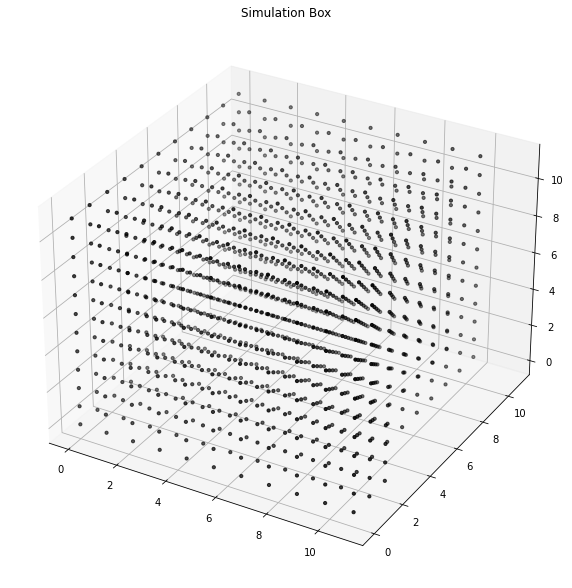

In [6]:
import numpy as np
import matplotlib.pyplot as plt

L = 12  # length of cell
N = 1348  # number of atoms
mdts = 5000  # number of time steps
dt = 0.01  # time step
dr = 0.1  # delta r for RDF
T = 1.25  # temperature

p = np.zeros((N, 3))
# Generate regular initial locations of each particle in the cell
nop = 0
for x in range(11):
    for y in range(11):
        for z in range(12):
            if nop < N:
                p[nop] = np.array([x * 1.091, y * 1.091, z])
                nop += 1
# Plotting the simulation box
fig = plt.figure(figsize=(10,11))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[:, 0], p[:, 1], p[:, 2], s=10, c='black')
ax.set_title('Simulation Box')
plt.show()

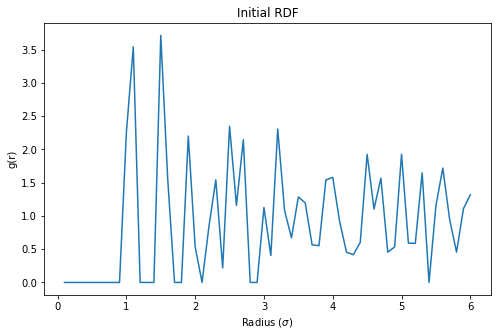

In [7]:
np.random.seed(0)  # Seed for reproducibility

# give an initial velocity to all
v = np.random.rand(N, 3) - 0.5
vi_squared = np.sum(v**2, axis=1)
ktd = np.sum(vi_squared)
# Correction of initial velocity
cf = np.sqrt((3 * N * T) / ktd)
v *= cf

# Compute differences
delta_xyz = p[:, None, :] - p[None, :, :]
delta_xyz -= L * np.round(delta_xyz / L)

rx = delta_xyz[:, :, 0]
ry = delta_xyz[:, :, 1]
rz = delta_xyz[:, :, 2]

# Compute distances
r = np.sqrt(rx**2 + ry**2 + rz**2)

# Compute potential energy incrementally
mask = np.logical_and((r <= 2.5),(r>0))
uE = np.sum(2 * ((1 / r[mask] ** 12) - 1 / r[mask] ** 6 - (1 / 2.5 ** 12) + 1 / 2.5 ** 6))

# Calculate the number of atom at different radius
Radius = np.arange(0.1, 6.1, 0.1)
grinit = np.zeros(60)
for i in range(1, 61):
    mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
    sp = np.sum(np.triu(mask, k=1))
    grinit[i - 1] = sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))
        
# Plotting RDF
plt.figure(figsize=(8,5))
plt.plot(Radius, grinit)
plt.title('Initial RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()

at = np.zeros((N, 3))
atdt = np.zeros((N, 3))

for i in range(N):
    Atem = np.zeros(3)
    for j in range(N):
        if r[i, j] > 0 and r[i, j] <= 2.5:
            factor = (24 / r[i, j]) * (2 * (1 / r[i, j]) ** 12 - (1 / r[i, j]) ** 6)
            Atem[0] += factor * (-rx[i, j] / r[i, j])
            Atem[1] += factor * (-ry[i, j] / r[i, j])
            Atem[2] += factor * (-rz[i, j] / r[i, j])

    at[i, 0] = Atem[0]
    at[i, 1] = Atem[1]
    at[i, 2] = Atem[2]


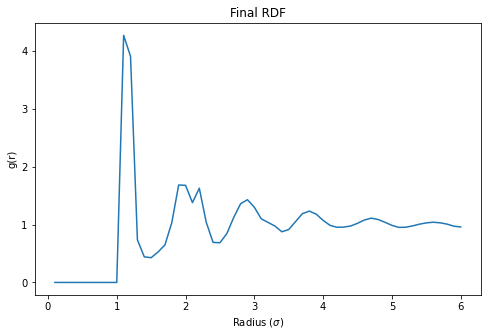

In [8]:
nn = 0
ng = 0
t = 0
gr = np.zeros(60)
uEplot = []
kEplot = []
Etplot = []
templot = []
time = []
# Main loop for all time steps
while t <= (dt * mdts):
    # Updating positions according to the velocity Verlet algorithm
    p += (dt * v) + ((dt ** 2) * at / 2)
        # Compute differences
    for i in range(N - 1):
        for j in range(i + 1, N):
            rx[i, j] = p[j, 0] - p[i, 0]
            ry[i, j] = p[j, 1] - p[i, 1]
            rz[i, j] = p[j, 2] - p[i, 2]
            rx[j, i] = -rx[i, j]
            ry[j, i] = -ry[i, j]
            rz[j, i] = -rz[i, j]
    # Compute differences
    #not working right
    # delta_xyz = p[:, np.newaxis, :] - p[np.newaxis, :, :]  
    # delta_xyz -= L * np.round(delta_xyz / L)
    rx = delta_xyz[:, :, 0]
    ry = delta_xyz[:, :, 1]
    rz = delta_xyz[:, :, 2]
    rx -= L * np.round(rx / L)
    ry -= L * np.round(ry / L)
    rz -= L * np.round(rz / L)
    # Compute distances
    r = np.sqrt(rx**2 + ry**2 + rz**2)
    # Compute potential energy incrementally
    mask = ((r <= 2.5)& (r > 0))
    uE = np.sum(2 * ((1 / r[mask] ** 12) - (1 / r[mask] ** 6) - (1 / 2.5 ** 12) + (1 / 2.5 ** 6)))

    # Computing the new acceleration
    for i in range(N):
        atem = np.zeros(3)
        for j in range(N):
            if (r[i, j] > 0 and r[i, j] <= 2.5):
                factor = (24 / r[i, j]) * (2 * (1 / r[i, j]** 12) - (1 / r[i, j]** 6))
                atem[0] += factor * (-rx[i, j] / r[i, j])
                atem[1] += factor * (-ry[i, j] / r[i, j])
                atem[2] += factor * (-rz[i, j] / r[i, j])

        atdt[i, 0] = atem[0]
        atdt[i, 1] = atem[1]
        atdt[i, 2] = atem[2]

    # Updating velocities according to the velocity Verlet algorithm
    v += dt * (at + atdt) / 2
    vi_squared = np.sum(v**2, axis=1)
    ktd = np.sum(vi_squared)

    # Calculating RDF in several time steps
    if ((nn % 50 == 0) and (nn > 2000)):
        ng += 1
        for i in range(1, 61):
            mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
            sp = np.sum(np.triu(mask, k=1))
            gr[i - 1] += sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))

    # Rescaling velocity in first 500 steps
    if nn < 500:
        cf = np.sqrt((3 * N * T) / ktd)
        v *= cf
        vi_squared = np.sum(v**2, axis=1)
        ktd = np.sum(vi_squared)
    # Computing kinetic energy and temperature
    kE = ktd / 2
    T = ktd / (3 * N)
    # Replacing old acceleration by new acceleration
    at = atdt

    # Computing the total energy
    Et = uE + kE
    t += dt
    nn += 1

    # Printing the energies and temperatures in a text file
    # print(f"time:{t} Kt:{kE} Ut:{uE} E:{Et} T:{T}\n")
    uEplot.append(uE)
    kEplot.append(kE)
    Etplot.append(Et)
    templot.append(T)
    time.append(t)


# Printing final average RDF in the text file
gr = gr / ng
# Plotting RDF
plt.figure(figsize=(8,5))
plt.plot(Radius, gr)
plt.title('Final RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()


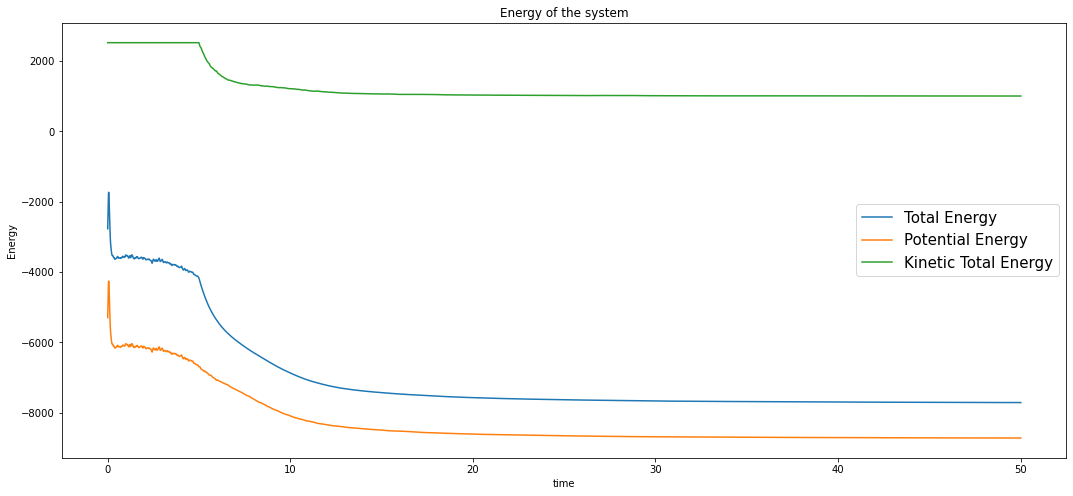

In [9]:
# Plotting Energies vs time
plt.figure(figsize=(18,8))
plt.plot(time, Etplot, label='Total Energy')
plt.plot(time, uEplot, label='Potential Energy')
plt.plot(time, kEplot, label='Kinetic Total Energy')
plt.title('Energy of the system')
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend(fontsize='15')
plt.show()